In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Models/GDSC_PDX_TCGA_Second_Strategy/Second_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/pathfindR/GDSC_PDX_TCGA_Second_Strategy/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
cetuximab_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/Cetuximab/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Second_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (EGFRi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (EGFRi)

GDSCE = pd.read_csv("GDSC_exprs.z.EGFRi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
683667,0.8924335646616343,-0.2118047645974752,-1.5249963829654445,-0.5512338119420259,-0.1375180480622428,-0.5276262991742051,-0.0305604198225781,0.5226216566753464,0.4877783097403741,0.2252883573642275,...,-0.0156845434045267,-0.1612071417519457,1.2033249282722671,2.7714836839186687,-0.3165072496327769,-0.8849200030571541,-0.5104734344593952,0.2984361940989172,-0.4349407065496763,0.4747633022523675
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (EGFRi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (EGFRi)

GDSCM = pd.read_csv("GDSC_mutations.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
683667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (EGFRi)

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = GDSCR.loc[GDSCR["drug"] != "Cetuximab", ]

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1
683665,1,-0.966773876200563,EKB-569,1,1,1
683665,0,2.43658649242319,Erlotinib,1,1,1


In [12]:
# print count of cell lines for each drug (EGFRi)

GDSCR["drug"].value_counts()

drug
EKB-569                770
Afatinib (rescreen)    757
CUDC-101               754
Afatinib               738
Gefitinib              734
HG-5-88-01             422
Lapatinib              371
Erlotinib              362
Name: count, dtype: int64

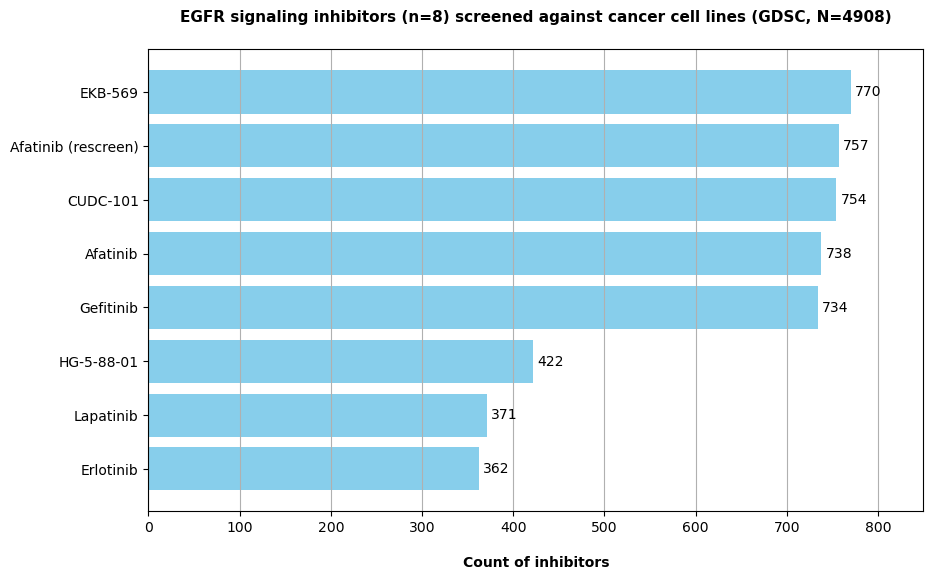

In [13]:
# plot EGFR signaling inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Cetuximab":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'EGFR signaling inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'EGFR Signaling Inhibitors with Their Counts (GDSC, Cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Cetuximab)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Cetuximab)

PDXEcetuximab = pd.read_csv("PDX_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEcetuximab = pd.DataFrame.transpose(PDXEcetuximab)
PDXEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1027,3.60061063639454,3.07817969365007,6.32765157689639,2.93005596217687,2.64304491832882,2.56618657438719,8.09168714940745,2.55483284192774,8.59989127217117,2.80664192172726,...,2.5997416042245,3.06591431154376,5.50994883395808,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,3.88458609037183,3.95227909263729,2.46055443755884
X-1119,3.54613916595946,3.07817969365007,7.46956729139981,4.20521626673769,2.929569339555,5.57576806896234,8.20319464923893,2.41443776874882,7.7754694329959,3.34200309260696,...,2.67274979347372,3.11395605082,8.98094314882696,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.81457724903364,3.95227909263729,2.84309989182372
X-1156,6.99909567844156,8.47130432034951,6.15135176832441,2.36952374925443,3.6713478754664,2.53437362934482,8.43809032488933,2.53376073162296,7.11948011162002,3.28816715734563,...,2.72150643954151,3.17396413482904,6.58328775150283,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.74727922278015,4.15062701412473,2.46987656241725


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Cetuximab)

TCGAEcetuximab = pd.read_csv("TCGA_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEcetuximab = pd.DataFrame.transpose(TCGAEcetuximab)
TCGAEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-BA-A4IG-01A,3.53364972782538,2.63169744477874,6.46913538384915,3.11954321356217,1.78425710174861,4.78953909500701,8.06446753523746,3.04479803527151,9.18974247446462,2.91775104542515,...,9.88694622925868,3.1254895591217,0,3.5074580817852,3.01824927947277,2.84422970206547,3.5035589781396,3.06737618948643,4.01010719689955,4.66295551081748
TCGA-CN-4731-01A,4.12585378817146,2.1506582678597,6.44489273685529,3.21409376420109,3.15286503399873,3.28492483066951,8.22062958425597,2.67285528315238,8.51873835886811,5.1735664410497,...,9.26858559890324,3.08733295866026,0,3.30585011523952,3.3487497141691,2.6930439585389,2.45792584512192,2.99299508958328,3.94714478968898,4.17054508896713
TCGA-CN-A49C-01A,4.37925369978313,3.43283585192836,6.59346803138021,3.11954321356217,3.31289809486857,3.10283527665291,8.2759744669096,2.74770994492163,8.98377132955025,3.96878580867183,...,9.71555609970402,3.0546486734275,0,3.67110924364761,3.04644627367641,2.61249547417883,3.00945260505516,3.06200290033863,5.05997145230091,4.13533467313432


In [17]:
# change directory to read PDX mutation dataset (Cetuximab)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (Cetuximab)

PDXMcetuximab = pd.read_csv("PDX_mutations.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMcetuximab.drop_duplicates(keep='last')
PDXMcetuximab = pd.DataFrame.transpose(PDXMcetuximab)
PDXMcetuximab = PDXMcetuximab.loc[:, ~PDXMcetuximab.columns.duplicated()]

PDXMcetuximab.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1119,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1156,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,-0.05,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (Cetuximab)

TCGAMcetuximab = pd.read_csv("TCGA_mutations.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMcetuximab.drop_duplicates(keep='last')
TCGAMcetuximab = pd.DataFrame.transpose(TCGAMcetuximab)
TCGAMcetuximab = TCGAMcetuximab.loc[:, ~TCGAMcetuximab.columns.duplicated()]

TCGAMcetuximab.head(3)

,27136,84993,56834,10256,6672,253461,90134,162333,345630,10278,...,374395,23173,646498,23016,10888,8347,29901,9445,766,2944
TCGA-BA-A4IG-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-4731-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-A49C-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (EGFRi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (EGFRi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEcetuximab.columns)
ls = ls.intersection(PDXMcetuximab.columns)
ls = ls.intersection(TCGAEcetuximab.columns)
ls = ls.intersection(TCGAMcetuximab.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 12203


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (EGFRi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 800


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (800, 12203)
GDSC # of common samples and genes (Mutation): (800, 12203)
GDSC # of samples (Response): 4908


In [25]:
# select shared samples between PDX expression and mutation datasets (Cetuximab) 

ls3 = PDXEcetuximab.index.intersection(PDXMcetuximab.index)

print(f"PDX # of common samples (Cetuximab): {ls3.shape[0]}")

PDX # of common samples (Cetuximab): 60


In [26]:
# select shared samples between TCGA expression and mutation datasets (Cetuximab) 

ls4 = TCGAEcetuximab.index.intersection(TCGAMcetuximab.index)

print(f"TCGA # of common samples (Cetuximab): {ls4.shape[0]}")

TCGA # of common samples (Cetuximab): 9


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (Cetuximab)

PDXEcetuximab = PDXEcetuximab.loc[ls3, ls]
PDXMcetuximab = PDXMcetuximab.loc[ls3, ls]

TCGAEcetuximab = TCGAEcetuximab.loc[ls4, ls]
TCGAMcetuximab = TCGAMcetuximab.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Cetuximab): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Mutation (Cetuximab): {PDXMcetuximab.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Cetuximab): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Mutation (Cetuximab): {TCGAMcetuximab.shape}")

PDX # of common samples and genes for Expression (Cetuximab): (60, 12203)
PDX # of common samples and genes for Mutation (Cetuximab): (60, 12203)

TCGA # of common samples and genes for Expression (Cetuximab): (9, 12203)
TCGA # of common samples and genes for Mutation (Cetuximab): (9, 12203)


In [28]:
# change directory to read DEGs (EGFRi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [29]:
# read DEGs (EGFRi)

DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors\n")

DEGs_filtered_data.head()

There are 1028 DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors



,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [30]:
# subset only DEGs with Frequency = 1

filter = DEGs_filtered_data["Frequency"] == 1
DEGs_freq_one =  DEGs_filtered_data[filter]
DEGs_freq_one.head()

,Gene Symbol,Frequency
607,N4BP2L1,1
608,PTPN12,1
609,ARHGAP4,1
610,TEX19,1
611,DOCK2,1


In [31]:
# read DEGs (Cetuximab) and select cetuximab-unique DEGs

DEGs_cetuximab_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                     sheet_name = "Cetuximab")

filter = DEGs_cetuximab_data["Gene.Symbol"].isin(DEGs_freq_one["Gene Symbol"])
only_cetuximab_degs = DEGs_cetuximab_data.loc[filter, "Gene.Symbol"]

print(f'There are {only_cetuximab_degs.shape[0]} DEGs unique to cetuximab, so they were removed from the DEGs list')

There are 1 DEGs unique to cetuximab, so they were removed from the DEGs list


In [32]:
# remove cetuximab-unique DEGs from feature set (MITOSISi)

filter = DEGs_filtered_data["Gene Symbol"].isin(only_cetuximab_degs)
DEGs_filtered_data = DEGs_filtered_data[~filter]

DEGs_filtered_data.head()

,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [33]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


1027

In [34]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [35]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1


In [36]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Afatinib',
 'Afatinib (rescreen)',
 'CUDC-101',
 'EKB-569',
 'Erlotinib',
 'Gefitinib',
 'HG-5-88-01',
 'Lapatinib'}

In [37]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([683665, 683665, 683665, 683665, 683665, 683665, 683665, 683665, 683667,
       683667,
       ...
       910930, 910941, 910941, 924248, 924248, 924248, 906849, 906849, 949162,
       949162],
      dtype='int64', length=4908)

In [38]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           507
leukemia             472
urogenital_system    455
lymphoma             431
aero_dig_tract       352
nervous_system       322
lung_SCLC            308
skin                 290
breast               258
large_intestine      246
digestive_system     231
bone                 227
neuroblastoma        193
pancreas             134
kidney               119
myeloma              100
soft_tissue           96
lung                  88
thyroid               79
Name: count, dtype: int64

In [39]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    312
lung_small_cell_carcinoma    308
glioma                       297
melanoma                     270
breast                       258
Name: count, dtype: int64

In [40]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['lung_NSCLC',
 'leukemia',
 'urogenital_system',
 'lymphoma',
 'aero_dig_tract',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'large_intestine',
 'digestive_system',
 'bone',
 'neuroblastoma',
 'pancreas',
 'kidney',
 'myeloma',
 'soft_tissue',
 'lung',
 'thyroid']

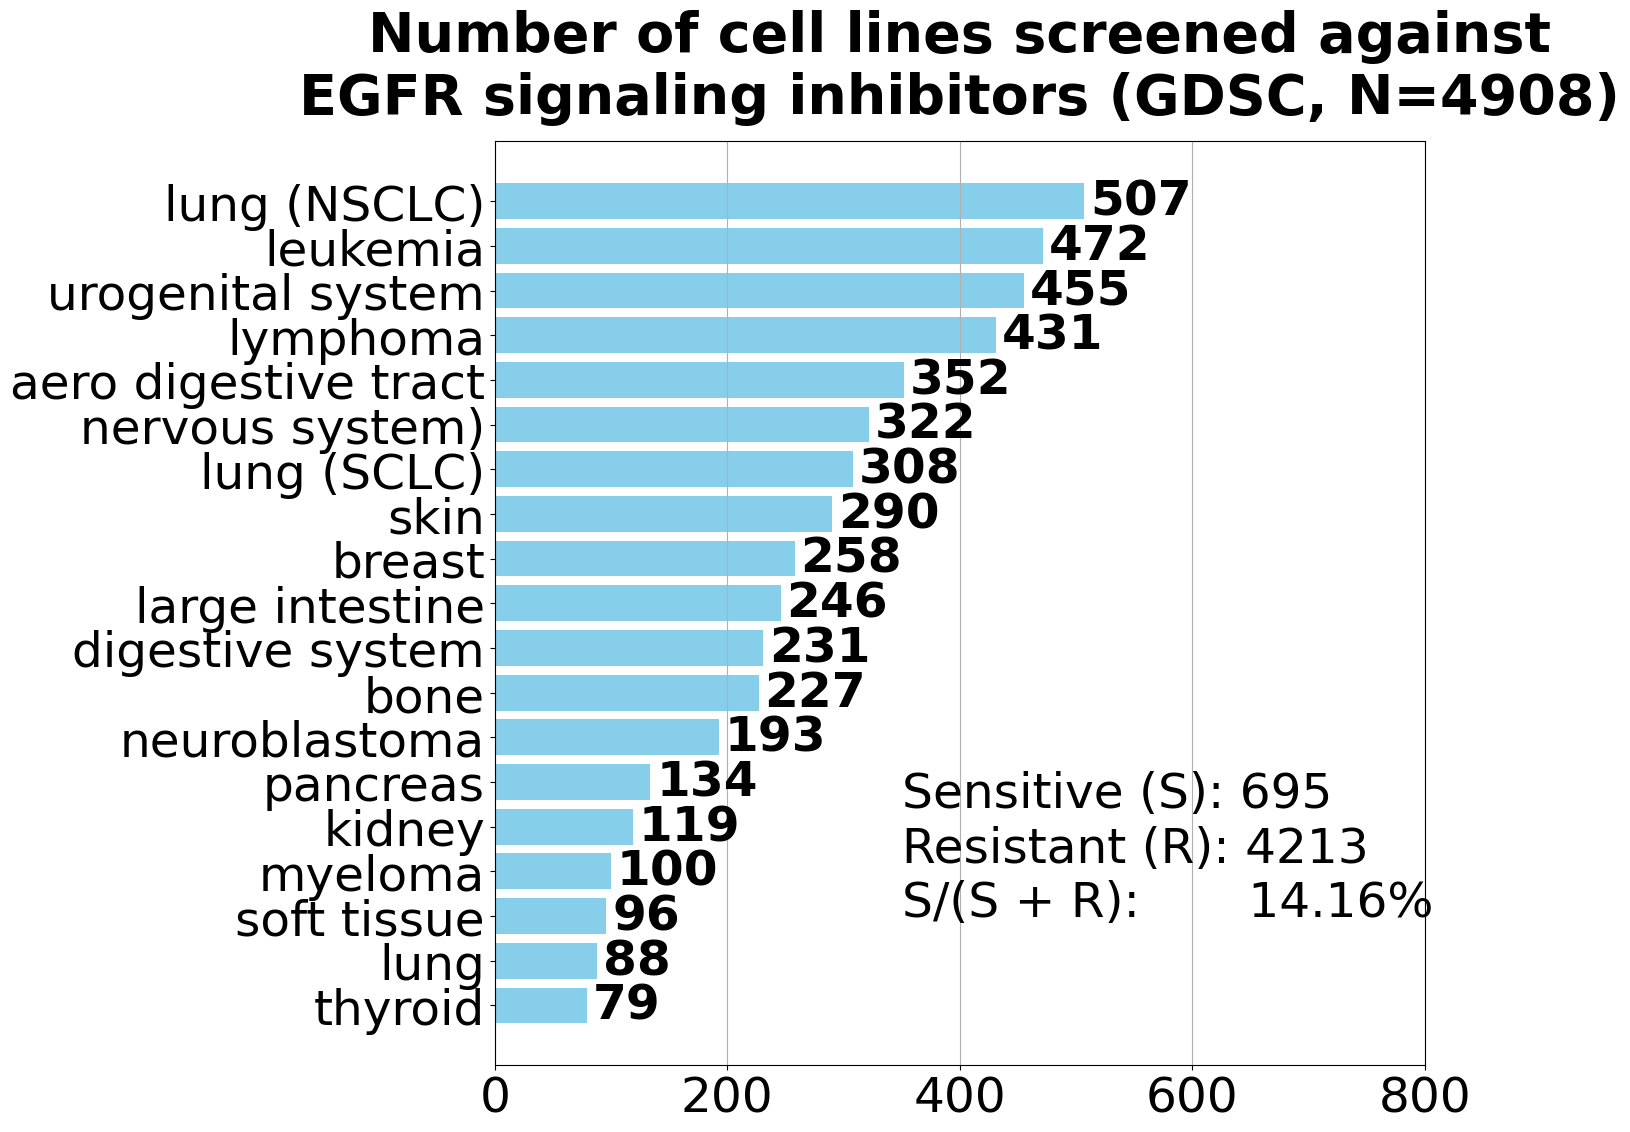

In [41]:
# plot tissue types of cancer cell lines treated with EGFR signaling inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names = ["lung (NSCLC)", "leukemia","urogenital system", "lymphoma","aero digestive tract","nervous system)", 
                "lung (SCLC)","skin",  "breast",  "large intestine", "digestive system", "bone","neuroblastoma",
                 "pancreas","kidney", "myeloma", "soft tissue", "lung", "thyroid"]
tissue_counts = list(gdsc_tissue_counts)

fig_A, ax = plt.subplots(figsize=(12, 12))
bars = ax.barh(tissue_names, tissue_counts, color='skyblue')

ax.set_xlabel(None)
ax.set_title(f'Number of cell lines screened against\nEGFR signaling inhibitors (GDSC, N={sum(tissue_counts)})',
             fontweight='bold',
             fontsize=40,
             pad=20)
ax.invert_yaxis()  # Invert the y-axis

ax.set_xlim(0, 800)  # Extend the x-axis limits
ax.tick_params(axis='y', labelsize=35)
ax.tick_params(axis='x', labelsize=35)

ax.grid(axis='x')

for bar, value in zip(bars, tissue_counts):
    ax.text(value + 5, bar.get_y() + bar.get_height()/2, str(value),
            va='center', fontsize=35, fontweight="bold")

ax.text(350, 16,
        f'Sensitive (S): {dat[["response"]].value_counts()[1]} \n'
        f'Resistant (R): {dat[["response"]].value_counts()[0]} \n'
        f'S/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%',
        fontsize=35, color='black')

fig_A.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with EGFR inhibitors (GDSC).png',
            format='png', bbox_inches='tight')

# Display the plot
plt.show()

In [42]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683667', '683667',
       ...
       '910930', '910941', '910941', '924248', '924248', '924248', '906849',
       '906849', '949162', '949162'],
      dtype='object', length=4908)

In [43]:
# convert Entrez gene IDs to integer

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [44]:
# filter GDSC expression and mutation datasets (EGFRi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEcetuximab = PDXEcetuximab.loc[:,ls5]
PDXMcetuximab = PDXMcetuximab.loc[:,ls5]
TCGAEcetuximab = TCGAEcetuximab.loc[:,ls5]
TCGAMcetuximab = TCGAMcetuximab.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Cetuximab (Expression): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Cetuximab (Mutation): {PDXMcetuximab.shape}\n")

print(f"TCGA # of common samples and genes for Cetuximab (Expression): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Cetuximab (Mutation): {TCGAMcetuximab.shape}")

GDSC # of common samples and genes (Expression): (4908, 750)
GDSC # of common samples and genes (Mutation): (4908, 750)
GDSC # of common samples (Response): 4908

PDX # of common samples and genes for Cetuximab (Expression): (60, 750)
PDX # of common samples and genes for Cetuximab (Mutation): (60, 750)

TCGA # of common samples and genes for Cetuximab (Expression): (9, 750)
TCGA # of common samples and genes for Cetuximab (Mutation): (9, 750)


In [45]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 0 0 0]


In [46]:
# change directory to read PDX and TCGA response datasets (Cetuximab)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [47]:
# read PDX response dataset (Cetuximab)

PDXRcetuximab = pd.read_csv("PDX_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRcetuximab.dropna(inplace=True)
PDXRcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRcetuximab["response"] = PDXRcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab_pdx = PDXRcetuximab["response"].values    

print(f"There are {Ytscetuximab_pdx.shape[0]} samples with response data in the PDX (Cetuximab)\n")
Ytscetuximab_pdx

There are 60 samples with response data in the PDX (Cetuximab)



array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [48]:
# read PDX dataset to select cohorts (Cetuximab)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "cetuximab",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0933,CRC
X-1027,CRC
X-1055,CRC
X-1119,CRC
X-1156,NSCLC


In [49]:
# merged PDX cohort table with PDX response dataset (Cetuximab)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRcetuximab,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
CRC      36
NSCLC    24
Name: count, dtype: int64

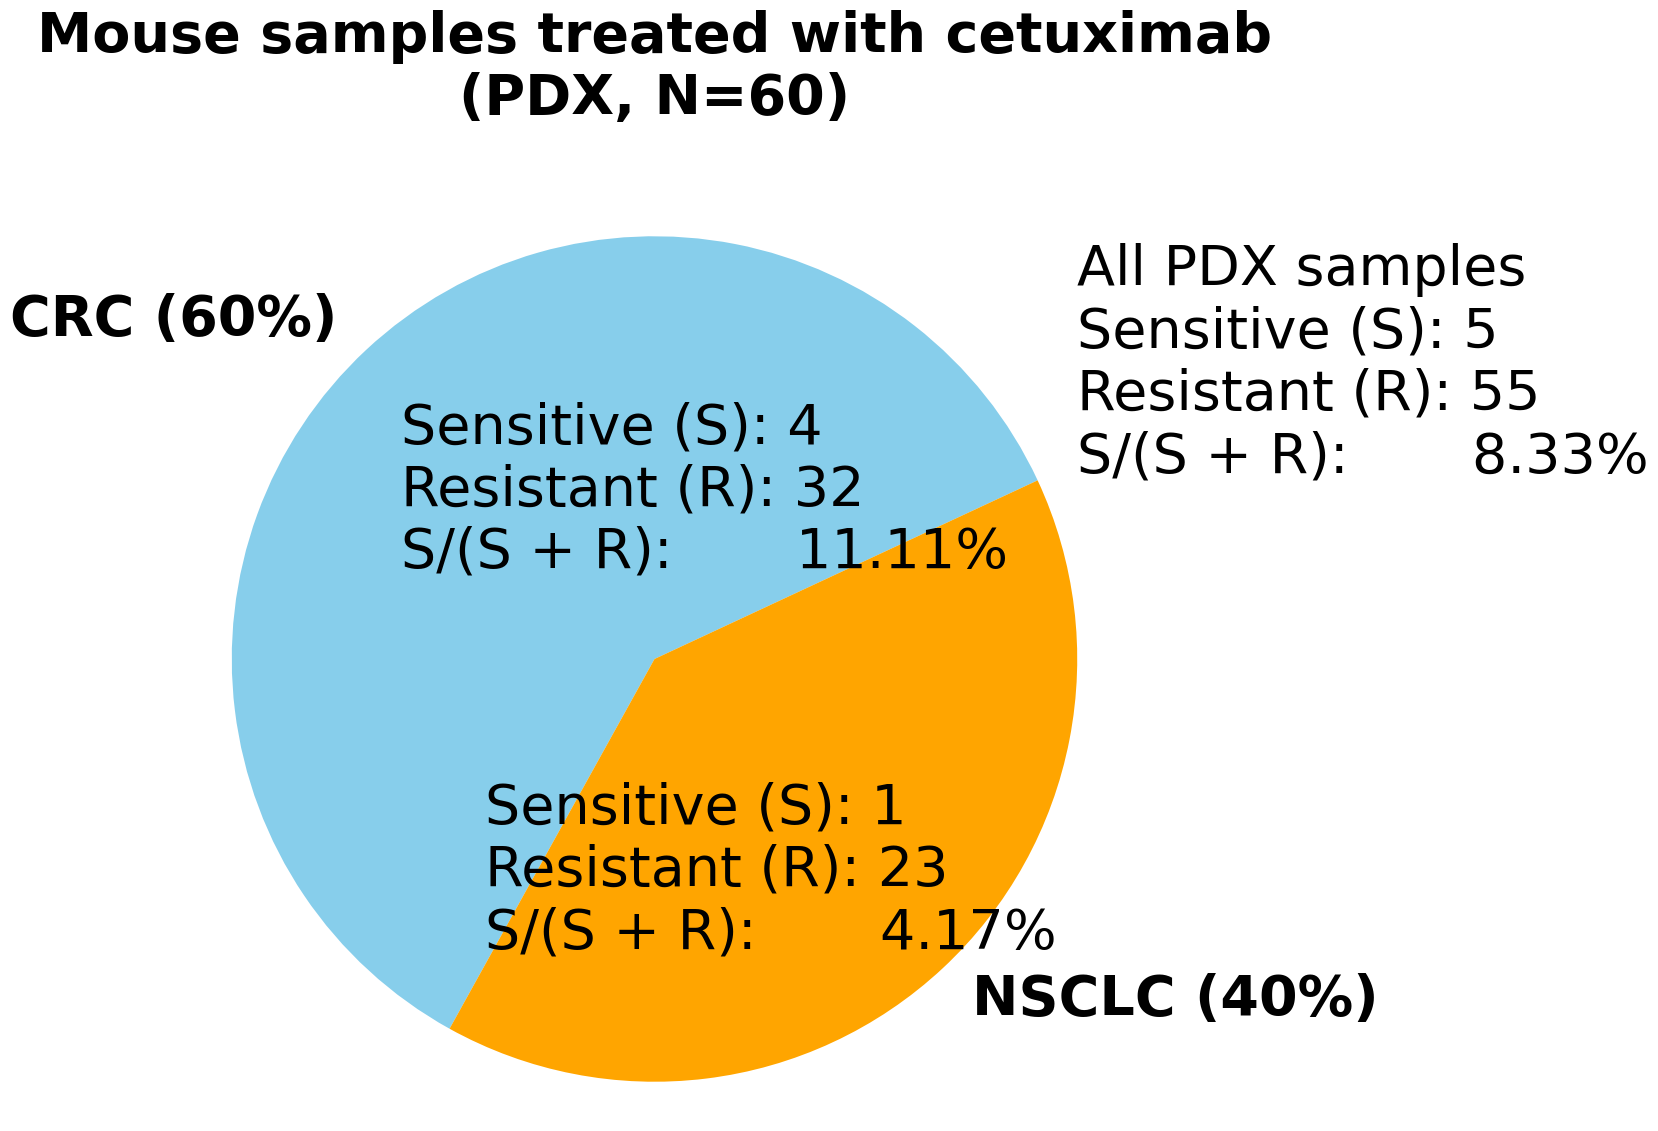

In [50]:
# plot tissue types of PDX samples 

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Assign the plot to variable fig_D
fig_D = plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=25, colors=['skyblue', 'orange'], textprops={'fontsize': 40, 'fontweight': 'bold'})
plt.title(f'Mouse samples treated with cetuximab\n(PDX, N={total})\n', fontweight="bold", pad=15, fontsize=40, loc="center")
plt.axis('equal')

plt.text(-0.6, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(-0.4, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1, 0)} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1, 0)/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All PDX samples\nSensitive (S): {PDXRcetuximab["response"].value_counts()[1]} \nResistant (R): {PDXRcetuximab["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(PDXRcetuximab["response"].value_counts()[1]/(sum(PDXRcetuximab["response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [51]:
# filter CRC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "CRC")
pdx_crc_samples = dat_pdx.loc[filter,].index
pdx_crc_samples

Index(['X-1027', 'X-1119', 'X-1167', 'X-1173', 'X-1270', 'X-1290', 'X-1303',
       'X-1329', 'X-1443', 'X-1479', 'X-1500', 'X-1536', 'X-1538', 'X-2145',
       'X-2182', 'X-2239', 'X-2403', 'X-2483', 'X-2484', 'X-2538', 'X-2573',
       'X-2659', 'X-2822', 'X-2846', 'X-2861', 'X-3093', 'X-3205', 'X-3224',
       'X-3671', 'X-3792', 'X-4087', 'X-5254', 'X-5405', 'X-5446', 'X-5495',
       'X-5578'],
      dtype='object')

In [52]:
# filter responses of CRC cohort samples (Cetuximab)

Ytscetuximab_pdx_crc = PDXRcetuximab.loc[pdx_crc_samples,"response"].values
Ytscetuximab_pdx_crc

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [53]:
# count of sensitive and resistant CRC samples (Cetuximab)

PDXRcetuximab.loc[pdx_crc_samples,"response"].value_counts()

response
0    32
1     4
Name: count, dtype: int64

In [54]:
# filter NSCLC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1658',
       'X-1725', 'X-1787', 'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980',
       'X-1993', 'X-2017', 'X-2042', 'X-2082', 'X-2088', 'X-2094', 'X-3029',
       'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [55]:
# filter responses of NSCLC cohort samples (Cetuximab)

Ytscetuximab_pdx_nsclc = PDXRcetuximab.loc[pdx_nsclc_samples,"response"].values
Ytscetuximab_pdx_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [56]:
# count of sensitive and resistant NSCLC samples (Cetuximab)

PDXRcetuximab.loc[pdx_nsclc_samples,"response"].value_counts()

response
0    23
1     1
Name: count, dtype: int64

In [57]:
# read TCGA response dataset (Cetuximab)

TCGARcetuximab = pd.read_csv("TCGA_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARcetuximab.dropna(inplace=True)
TCGARcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARcetuximab["response"] = TCGARcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab_tcga = TCGARcetuximab["response"].values    

print(f"There are {Ytscetuximab_tcga.shape[0]} samples with response data in the TCGA (Cetuximab)\n")
Ytscetuximab_tcga

There are 9 samples with response data in the TCGA (Cetuximab)



array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [58]:
# TCGA cohort table with TCGA response dataset (Cetuximab)

dat_tcga = TCGARcetuximab["cohort"]

dat_tcga.value_counts()

cohort
HNSC    9
Name: count, dtype: int64

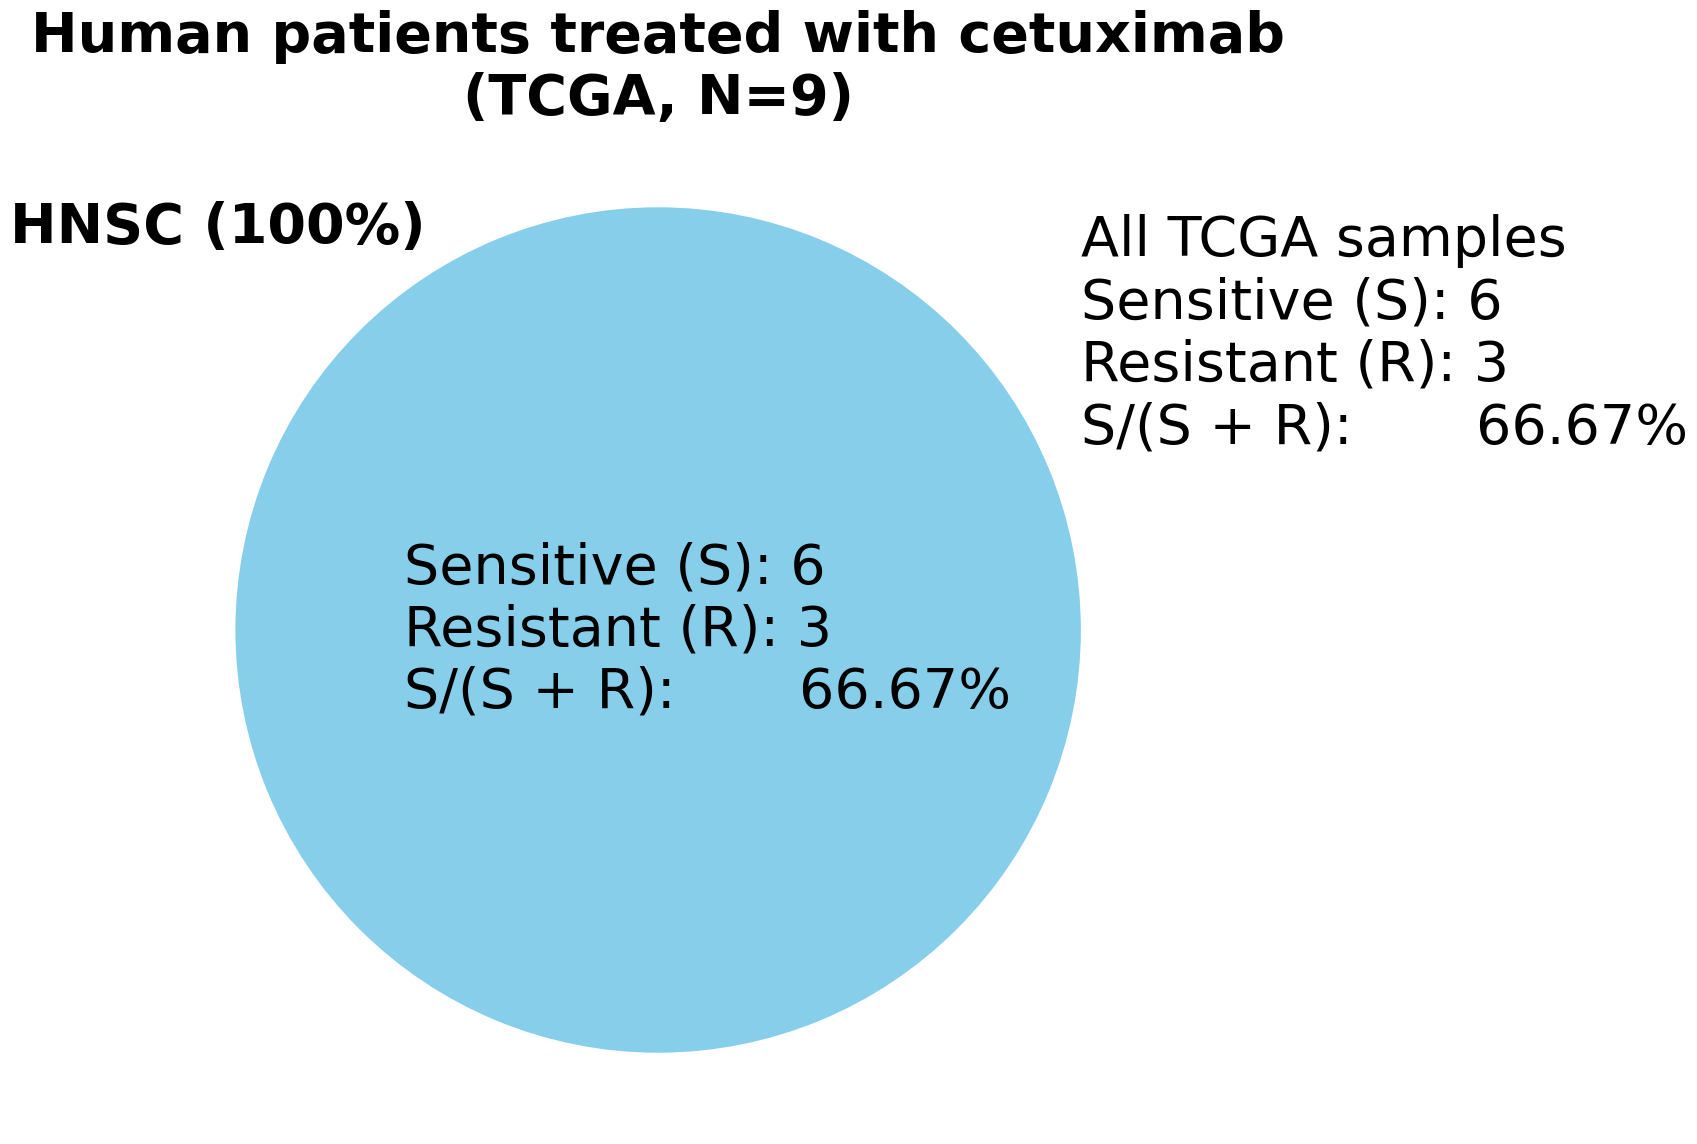

In [59]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Assign the plot to variable fig_E
fig_E = plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-60, colors=['skyblue', 'lightgreen', 'salmon', 'orange','pink'], textprops={'fontsize': 40, 'fontweight': 'bold'})
plt.title(f'Human patients treated with cetuximab\n(TCGA, N={total})', fontweight = "bold", fontsize = 40 )
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.6, 0, 
         f'Sensitive (S): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/(sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARcetuximab["response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARcetuximab["response"].value_counts()[1]/(sum(TCGARcetuximab["response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [60]:
# filter HNSC cohort samples (Cetuximab)

filter = (TCGARcetuximab["cohort"] == "HNSC")
tcga_hnsc_samples = dat_tcga.loc[filter,].index
tcga_hnsc_samples

Index(['TCGA-BA-A4IG-01A', 'TCGA-CN-4731-01A', 'TCGA-CN-A49C-01A',
       'TCGA-CN-A6V1-01A', 'TCGA-CR-7404-01A', 'TCGA-DQ-7596-01A',
       'TCGA-HD-8224-01A', 'TCGA-KU-A6H8-01A', 'TCGA-RS-A6TO-01A'],
      dtype='object', name='sample')

In [61]:
# filter responses of HNSC cohort samples (Cetuximab)

Ytscetuximab_tcga_hnsc = TCGARcetuximab.loc[tcga_hnsc_samples,"response"].values
Ytscetuximab_tcga_hnsc

array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [62]:
# count of sensitive and resistance HNSC samples (Cetuximab)

TCGARcetuximab.loc[tcga_hnsc_samples,"response"].value_counts()

response
1    6
0    3
Name: count, dtype: int64

In [63]:
# maximum iteration

max_iter = 50

In [64]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 16
hdm2 = 16
rate1 = 0.4
rate2 = 0.3
rate3 = 0.3

In [65]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEcetuximab_pdx = scalerGDSC.transform(PDXEcetuximab.values) 
X_testEcetuximab_pdx_crc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_crc_samples,].values) 
X_testEcetuximab_pdx_nsclc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_nsclc_samples,].values) 

X_testEcetuximab_tcga = scalerGDSC.transform(TCGAEcetuximab.values)    
X_testEcetuximab_tcga_hnsc = scalerGDSC.transform(TCGAEcetuximab.loc[tcga_hnsc_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMcetuximab_pdx = np.nan_to_num(PDXMcetuximab.values.astype(np.float32))
X_testMcetuximab_pdx_crc = np.nan_to_num(PDXMcetuximab.loc[pdx_crc_samples,].values.astype(np.float32))
X_testMcetuximab_pdx_nsclc = np.nan_to_num(PDXMcetuximab.loc[pdx_nsclc_samples,].values.astype(np.float32))
X_testMcetuximab_tcga = np.nan_to_num(TCGAMcetuximab.values.astype(np.float32))
X_testMcetuximab_tcga_hnsc = np.nan_to_num(TCGAMcetuximab.loc[tcga_hnsc_samples,].values.astype(np.float32))

TX_testEcetuximab_pdx = torch.FloatTensor(X_testEcetuximab_pdx)
TX_testEcetuximab_pdx_crc = torch.FloatTensor(X_testEcetuximab_pdx_crc)
TX_testEcetuximab_pdx_nsclc = torch.FloatTensor(X_testEcetuximab_pdx_nsclc)

TX_testMcetuximab_pdx = torch.FloatTensor(X_testMcetuximab_pdx.astype(np.float32))
TX_testMcetuximab_pdx_crc = torch.FloatTensor(X_testMcetuximab_pdx_crc.astype(np.float32))
TX_testMcetuximab_pdx_nsclc = torch.FloatTensor(X_testMcetuximab_pdx_nsclc.astype(np.float32))

ty_testEcetuximab_pdx = torch.FloatTensor(Ytscetuximab_pdx.astype(int))
ty_testEcetuximab_pdx_crc = torch.FloatTensor(Ytscetuximab_pdx_crc.astype(int))
ty_testEcetuximab_pdx_nsclc = torch.FloatTensor(Ytscetuximab_pdx_nsclc.astype(int))

TX_testEcetuximab_tcga = torch.FloatTensor(X_testEcetuximab_tcga)
TX_testEcetuximab_tcga_hnsc = torch.FloatTensor(X_testEcetuximab_tcga_hnsc)

TX_testMcetuximab_tcga = torch.FloatTensor(X_testMcetuximab_tcga.astype(np.float32))
TX_testMcetuximab_tcga_hnsc = torch.FloatTensor(X_testMcetuximab_tcga_hnsc.astype(np.float32))

ty_testEcetuximab_tcga = torch.FloatTensor(Ytscetuximab_tcga.astype(int))
ty_testEcetuximab_tcga_hnsc = torch.FloatTensor(Ytscetuximab_tcga_hnsc.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy.pt")

Clas = torch.load(models_dir + "Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETcetuximab_pdx = AutoencoderE(TX_testEcetuximab_pdx)
ZMTcetuximab_pdx = AutoencoderM(TX_testMcetuximab_pdx)
ZTTcetuximab_pdx = torch.cat((ZETcetuximab_pdx, ZMTcetuximab_pdx), 1)
ZTTcetuximab_pdx = F.normalize(ZTTcetuximab_pdx, p=2, dim=0)
PredTcetuximab_pdx = Clas(ZTTcetuximab_pdx)
AUCTcetuximab_pdx = roc_auc_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())
AUCTcetuximab_pdx_aucpr = average_precision_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())

ZETcetuximab_pdx_crc = AutoencoderE(TX_testEcetuximab_pdx_crc)
ZMTcetuximab_pdx_crc = AutoencoderM(TX_testMcetuximab_pdx_crc)
ZTTcetuximab_pdx_crc = torch.cat((ZETcetuximab_pdx_crc, ZMTcetuximab_pdx_crc), 1)
ZTTcetuximab_pdx_crc = F.normalize(ZTTcetuximab_pdx_crc, p=2, dim=0)
PredTcetuximab_pdx_crc = Clas(ZTTcetuximab_pdx_crc)
AUCTcetuximab_pdx_crc = roc_auc_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())
AUCTcetuximab_pdx_crc_aucpr = average_precision_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())

ZETcetuximab_pdx_nsclc = AutoencoderE(TX_testEcetuximab_pdx_nsclc)
ZMTcetuximab_pdx_nsclc = AutoencoderM(TX_testMcetuximab_pdx_nsclc)
ZTTcetuximab_pdx_nsclc = torch.cat((ZETcetuximab_pdx_nsclc, ZMTcetuximab_pdx_nsclc), 1)
ZTTcetuximab_pdx_nsclc = F.normalize(ZTTcetuximab_pdx_nsclc, p=2, dim=0)
PredTcetuximab_pdx_nsclc = Clas(ZTTcetuximab_pdx_nsclc)
AUCTcetuximab_pdx_nsclc = roc_auc_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())
AUCTcetuximab_pdx_nsclc_aucpr = average_precision_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())

ZETcetuximab_tcga = AutoencoderE(TX_testEcetuximab_tcga)
ZMTcetuximab_tcga = AutoencoderM(TX_testMcetuximab_tcga)
ZTTcetuximab_tcga = torch.cat((ZETcetuximab_tcga, ZMTcetuximab_tcga), 1)
ZTTcetuximab_tcga = F.normalize(ZTTcetuximab_tcga, p=2, dim=0)
PredTcetuximab_tcga = Clas(ZTTcetuximab_tcga)
AUCTcetuximab_tcga = roc_auc_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())
AUCTcetuximab_tcga_aucpr = average_precision_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())

ZETcetuximab_tcga_hnsc = AutoencoderE(TX_testEcetuximab_tcga_hnsc)
ZMTcetuximab_tcga_hnsc = AutoencoderM(TX_testMcetuximab_tcga_hnsc)
ZTTcetuximab_tcga_hnsc = torch.cat((ZETcetuximab_tcga_hnsc, ZMTcetuximab_tcga_hnsc), 1)
ZTTcetuximab_tcga_hnsc = F.normalize(ZTTcetuximab_tcga_hnsc, p=2, dim=0)
PredTcetuximab_tcga_hnsc = Clas(ZTTcetuximab_tcga_hnsc)
AUCTcetuximab_tcga_hnsc = roc_auc_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())
AUCTcetuximab_tcga_hnsc_aucpr = average_precision_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTcetuximab_pdx_finetuned = dict()
AUCTcetuximab_tcga_finetuned = dict()
AUCTcetuximab_pdx_crc_finetuned = dict()
AUCTcetuximab_pdx_nsclc_finetuned = dict()
AUCTcetuximab_tcga_hnsc_finetuned = dict()
AUCTcetuximab_pdx_aucpr_finetuned = dict()
AUCTcetuximab_tcga_aucpr_finetuned = dict()
AUCTcetuximab_pdx_crc_aucpr_finetuned = dict()
AUCTcetuximab_pdx_nsclc_aucpr_finetuned = dict()
AUCTcetuximab_tcga_hnsc_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETcetuximab_pdx = AutoencoderE_finetuned(TX_testEcetuximab_pdx)
   ZMTcetuximab_pdx = AutoencoderM_finetuned(TX_testMcetuximab_pdx)
   ZTTcetuximab_pdx = torch.cat((ZETcetuximab_pdx, ZMTcetuximab_pdx), 1)
   ZTTcetuximab_pdx = F.normalize(ZTTcetuximab_pdx, p=2, dim=0)
   PredTcetuximab_pdx = Clas_finetuned(ZTTcetuximab_pdx)
   AUCTcetuximab_pdx_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())
   AUCTcetuximab_pdx_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())

   ZETcetuximab_pdx_crc = AutoencoderE_finetuned(TX_testEcetuximab_pdx_crc)
   ZMTcetuximab_pdx_crc = AutoencoderM_finetuned(TX_testMcetuximab_pdx_crc)
   ZTTcetuximab_pdx_crc = torch.cat((ZETcetuximab_pdx_crc, ZMTcetuximab_pdx_crc), 1)
   ZTTcetuximab_pdx_crc = F.normalize(ZTTcetuximab_pdx_crc, p=2, dim=0)
   PredTcetuximab_pdx_crc = Clas_finetuned(ZTTcetuximab_pdx_crc)
   AUCTcetuximab_pdx_crc_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())
   AUCTcetuximab_pdx_crc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())

   ZETcetuximab_pdx_nsclc = AutoencoderE_finetuned(TX_testEcetuximab_pdx_nsclc)
   ZMTcetuximab_pdx_nsclc = AutoencoderM_finetuned(TX_testMcetuximab_pdx_nsclc)
   ZTTcetuximab_pdx_nsclc = torch.cat((ZETcetuximab_pdx_nsclc, ZMTcetuximab_pdx_nsclc), 1)
   ZTTcetuximab_pdx_nsclc = F.normalize(ZTTcetuximab_pdx_nsclc, p=2, dim=0)
   PredTcetuximab_pdx_nsclc = Clas_finetuned(ZTTcetuximab_pdx_nsclc)
   AUCTcetuximab_pdx_nsclc_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())
   AUCTcetuximab_pdx_nsclc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())

   ZETcetuximab_tcga = AutoencoderE_finetuned(TX_testEcetuximab_tcga)
   ZMTcetuximab_tcga = AutoencoderM_finetuned(TX_testMcetuximab_tcga)
   ZTTcetuximab_tcga = torch.cat((ZETcetuximab_tcga, ZMTcetuximab_tcga), 1)
   ZTTcetuximab_tcga = F.normalize(ZTTcetuximab_tcga, p=2, dim=0)
   PredTcetuximab_tcga = Clas_finetuned(ZTTcetuximab_tcga)
   AUCTcetuximab_tcga_finetuned[iter] = roc_auc_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())
   AUCTcetuximab_tcga_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())

   ZETcetuximab_tcga_hnsc = AutoencoderE_finetuned(TX_testEcetuximab_tcga_hnsc)
   ZMTcetuximab_tcga_hnsc = AutoencoderM_finetuned(TX_testMcetuximab_tcga_hnsc)
   ZTTcetuximab_tcga_hnsc = torch.cat((ZETcetuximab_tcga_hnsc, ZMTcetuximab_tcga_hnsc), 1)
   ZTTcetuximab_tcga_hnsc = F.normalize(ZTTcetuximab_tcga_hnsc, p=2, dim=0)
   PredTcetuximab_tcga_hnsc = Clas_finetuned(ZTTcetuximab_tcga_hnsc)
   AUCTcetuximab_tcga_hnsc_finetuned[iter] = roc_auc_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())
   AUCTcetuximab_tcga_hnsc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())

max_key_pdx = max(AUCTcetuximab_pdx_aucpr_finetuned, key=AUCTcetuximab_pdx_aucpr_finetuned.get)
max_key_pdx_crc = max(AUCTcetuximab_pdx_crc_aucpr_finetuned, key=AUCTcetuximab_pdx_crc_aucpr_finetuned.get)
max_key_pdx_nsclc = max(AUCTcetuximab_pdx_nsclc_aucpr_finetuned, key=AUCTcetuximab_pdx_nsclc_aucpr_finetuned.get)
max_key_tcga = max(AUCTcetuximab_tcga_aucpr_finetuned, key=AUCTcetuximab_tcga_aucpr_finetuned.get)
max_key_tcga_hnsc = max(AUCTcetuximab_tcga_hnsc_aucpr_finetuned, key=AUCTcetuximab_tcga_hnsc_aucpr_finetuned.get)

print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Cetuximab): {round(AUCTcetuximab_pdx,2)}")
print(f"PDX - Test AUCPR (Cetuximab): {round(AUCTcetuximab_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc_aucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab): {round(AUCTcetuximab_tcga,2)}")
print(f"TCGA - Test AUCPR (Cetuximab): {round(AUCTcetuximab_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc,2)}")
print(f"TCGA - Test AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc_aucpr,2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx_crc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUC (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_pdx_crc_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx_nsclc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_nsclc],2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_pdx_nsclc_finetuned[max_key_pdx_nsclc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_pdx_nsclc_aucpr_finetuned[max_key_pdx_nsclc],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_tcga_hnsc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_hnsc],2)}")
print(f"TCGA - Test AUC (Cetuximab, HNSC, Finetuned): {round(AUCTcetuximab_tcga_hnsc_finetuned[max_key_tcga_hnsc],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, HNSC, Finetuned): {round(AUCTcetuximab_tcga_hnsc_aucpr_finetuned[max_key_tcga_hnsc],2)}\n\n")

print("Models for maximum finetuning (Cetuximab, PDX)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Cetuximab, PDX, CRC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_crc}.pt")

print("\nFModels for maximum finetuning (Cetuximab, PDX, NSCLC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")

print("\nModels for maximum finetuning (Cetuximab, TCGA)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Cetuximab, TCGA, HNSC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Second_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")


GDSC - Training AUC (EGFRi): 0.83
GDSC - Training AUCPR (EGFRi): 0.46
PDX - Test AUC (Cetuximab): 0.56
PDX - Test AUCPR (Cetuximab): 0.16
PDX - Test AUC (Cetuximab, CRC): 0.53
PDX - Test AUCPR (Cetuximab, CRC): 0.17
PDX - Test AUC (Cetuximab, NSCLC): 0.96
PDX - Test AUCPR (Cetuximab, NSCLC): 0.5
TCGA - Test AUC (Cetuximab): 0.67
TCGA - Test AUCPR (Cetuximab): 0.84
TCGA - Test AUC (Cetuximab, HNSC): 0.67
TCGA - Test AUCPR (Cetuximab, HNSC): 0.84

GDSC - Training AUC (EGFRi, Finetuned): 0.83
GDSC - Training AUCPR (EGFRi, Finetuned): 0.46
PDX - Test AUC (Cetuximab, Finetuned): 0.57
PDX - Test AUCPR (Cetuximab, Finetuned): 0.19

GDSC - Training AUC (EGFRi, Finetuned): 0.84
GDSC - Training AUCPR (EGFRi, Finetuned): 0.47
PDX - Test AUC (Cetuximab, CRC, Finetuned): 0.55
PDX - Test AUCPR (Cetuximab, CRC, Finetuned): 0.18

GDSC - Training AUC (EGFRi, Finetuned): 0.84
GDSC - Training AUCPR (EGFRi, Finetuned): 0.46
PDX - Test AUC (Cetuximab, NSCLC, Finetuned): 0.96
PDX - Test AUCPR (Cetuximab, NS

In [66]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=750, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [67]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=750, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [68]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [69]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTcetuximab_pdx,2), round(AUCTcetuximab_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTcetuximab_pdx_aucpr,2), round(AUCTcetuximab_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-CRC)":  [round(AUCTcetuximab_pdx_crc,2), round(AUCTcetuximab_pdx_crc_finetuned[max_key_pdx_crc],2)],
       "AUCPR (PDX-CRC)": [round(AUCTcetuximab_pdx_crc_aucpr,2), round(AUCTcetuximab_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)],
       "AUC (PDX-NSCLC)":  [round(AUCTcetuximab_pdx_nsclc,2), round(AUCTcetuximab_pdx_nsclc_finetuned[max_key_pdx_nsclc],2)],
       "AUCPR (PDX-NSCLC)": [round(AUCTcetuximab_pdx_nsclc_aucpr,2), round(AUCTcetuximab_pdx_nsclc_aucpr_finetuned[max_key_pdx_nsclc],2)],
       "AUC (TCGA)": [round(AUCTcetuximab_tcga,2), round(AUCTcetuximab_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTcetuximab_tcga_aucpr,2), round(AUCTcetuximab_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-HNSC)":  [round(AUCTcetuximab_tcga_hnsc,2), round(AUCTcetuximab_tcga_hnsc_finetuned[max_key_tcga_hnsc],2)],
       "AUCPR (TCGA-HNSC)": [round(AUCTcetuximab_tcga_hnsc_aucpr,2), round(AUCTcetuximab_tcga_hnsc_aucpr_finetuned[max_key_tcga_hnsc],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_EGFRi_Cetuximab_Second_Strategy.tsv",
                     sep = "\t",
                     index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytscetuximab_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytscetuximab_pdx)) + ")",
    "AUC (PDX-CRC)": "AUC (PDX-CRC, N=" + str(len(Ytscetuximab_pdx_crc)) + ")",
    "AUCPR (PDX-CRC)": "AUCPR (PDX-CRC, N=" + str(len(Ytscetuximab_pdx_crc)) + ")",
    "AUC (PDX-NSCLC)": "AUC (PDX-NSCLC, N=" + str(len(Ytscetuximab_pdx_nsclc)) + ")",
    "AUCPR (PDX-NSCLC)": "AUCPR (PDX-NSCLC, N=" + str(len(Ytscetuximab_pdx_nsclc)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytscetuximab_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytscetuximab_tcga)) + ")",
    "AUC (TCGA-HNSC)": "AUC (TCGA-HNSC, N=" + str(len(Ytscetuximab_tcga_hnsc)) + ")",
    "AUCPR (TCGA-HNSC)": "AUCPR (TCGA-HNSC, N=" + str(len(Ytscetuximab_tcga_hnsc)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=4908)","AUCPR (GDSC, N=4908)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.83,0.46,0.56,0.16,0.53,0.17,0.96,0.5,0.67,0.84,0.67,0.84,4908,750
1,Expr + Mut (Fine-tuned),0.83,0.46,0.57,0.19,0.55,0.18,0.96,0.5,0.83,0.94,0.83,0.94,4908,750


In [70]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_EGFRi_Cetuximab_Second_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_EGFRi_Cetuximab_Second_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=4908)","AUCPR (GDSC, N=4908)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,,,
Expr + Mut + CNA,0.84,0.47,0.46,0.09,0.65,0.17,0.3,0.06,0.67,0.8,0.67,0.8,4908,708
Expr + Mut + CNA (Fine-tuned),0.85,0.48,0.55,0.1,0.57,0.19,0.74,0.14,0.72,0.82,0.72,0.82,4908,708
Expr + CNA,0.84,0.47,0.51,0.1,0.62,0.2,0.39,0.07,0.61,0.78,0.61,0.78,4908,940
Expr + CNA (Fine-tuned),0.84,0.47,0.53,0.11,0.7,0.3,0.52,0.08,0.67,0.8,0.67,0.8,4908,940
Expr + Mut,0.83,0.46,0.56,0.16,0.53,0.17,0.96,0.5,0.67,0.84,0.67,0.84,4908,750
Expr + Mut (Fine-tuned),0.83,0.46,0.57,0.19,0.55,0.18,0.96,0.5,0.83,0.94,0.83,0.94,4908,750


In [71]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytscetuximab_pdx))})",
                               f"AUC (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})",
                               f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})",
                               f"AUC (TCGA, N={str(len(Ytscetuximab_tcga))})",
                               f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytscetuximab_pdx))})": f"PDX (N={str(len(Ytscetuximab_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_pdx_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_pdx_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytscetuximab_tcga))})": f"TCGA (N={str(len(Ytscetuximab_tcga))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_tcga_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=4908, p=750\nS=695, R=4213, S/N=0.14)","PDX (N=60, p=750\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=750\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=750\nS=1, R=23, S/N=0.04)","TCGA (N=9, p=750\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=750\nS=6, R=3, S/N=0.67)"
Data,,,,,,
Expr + Mut + CNA,0.84,0.46,0.65,0.3,0.67,0.67
Expr + Mut + CNA (Fine-tuned),0.85,0.55,0.57,0.74,0.72,0.72
Expr + CNA,0.84,0.51,0.62,0.39,0.61,0.61
Expr + CNA (Fine-tuned),0.84,0.53,0.7,0.52,0.67,0.67
Expr + Mut,0.83,0.56,0.53,0.96,0.67,0.67
Expr + Mut (Fine-tuned),0.83,0.57,0.55,0.96,0.83,0.83


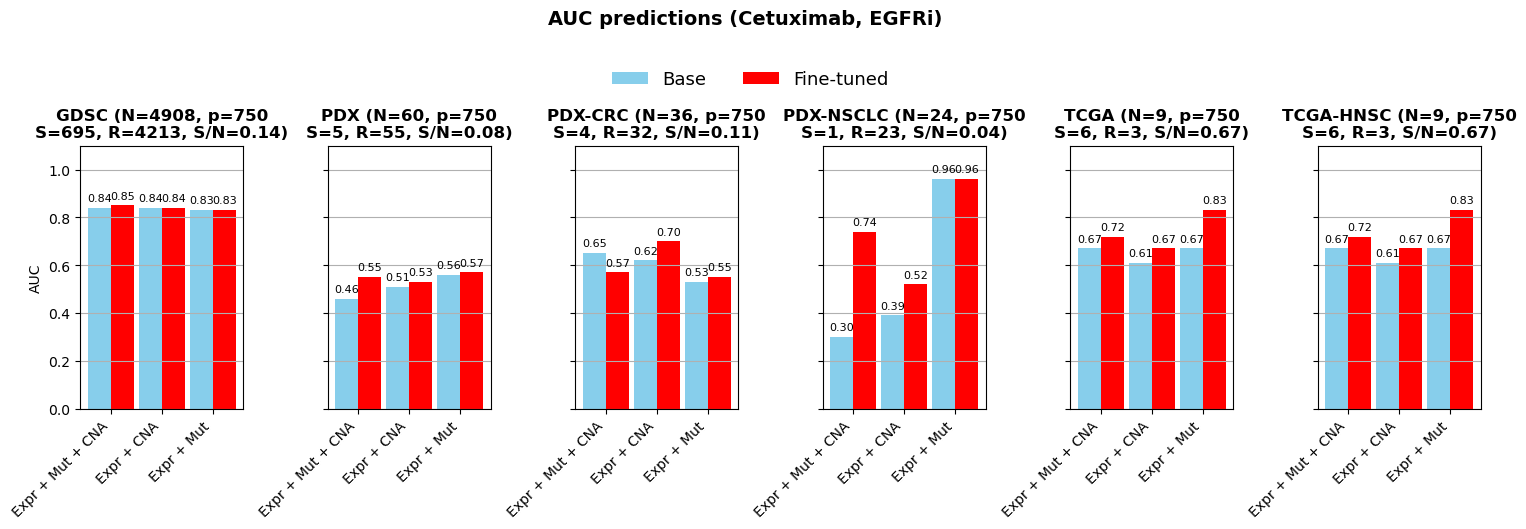

In [72]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Cetuximab, EGFRi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Cetuximab, EGFRi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [73]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytscetuximab_pdx))})",
                               f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})",
                               f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})",
                               f"AUCPR (TCGA, N={str(len(Ytscetuximab_tcga))})",
                               f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytscetuximab_pdx))})": f"PDX (N={str(len(Ytscetuximab_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_pdx_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_pdx_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytscetuximab_tcga))})": f"TCGA (N={str(len(Ytscetuximab_tcga))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_tcga_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=4908, p=750\nS=695, R=4213, S/N=0.14)","PDX (N=60, p=750\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=750\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=750\nS=1, R=23, S/N=0.04)","TCGA (N=9, p=750\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=750\nS=6, R=3, S/N=0.67)"
Data,,,,,,
Expr + Mut + CNA,0.47,0.09,0.17,0.06,0.8,0.8
Expr + Mut + CNA (Fine-tuned),0.48,0.1,0.19,0.14,0.82,0.82
Expr + CNA,0.47,0.1,0.2,0.07,0.78,0.78
Expr + CNA (Fine-tuned),0.47,0.11,0.3,0.08,0.8,0.8
Expr + Mut,0.46,0.16,0.17,0.5,0.84,0.84
Expr + Mut (Fine-tuned),0.46,0.19,0.18,0.5,0.94,0.94


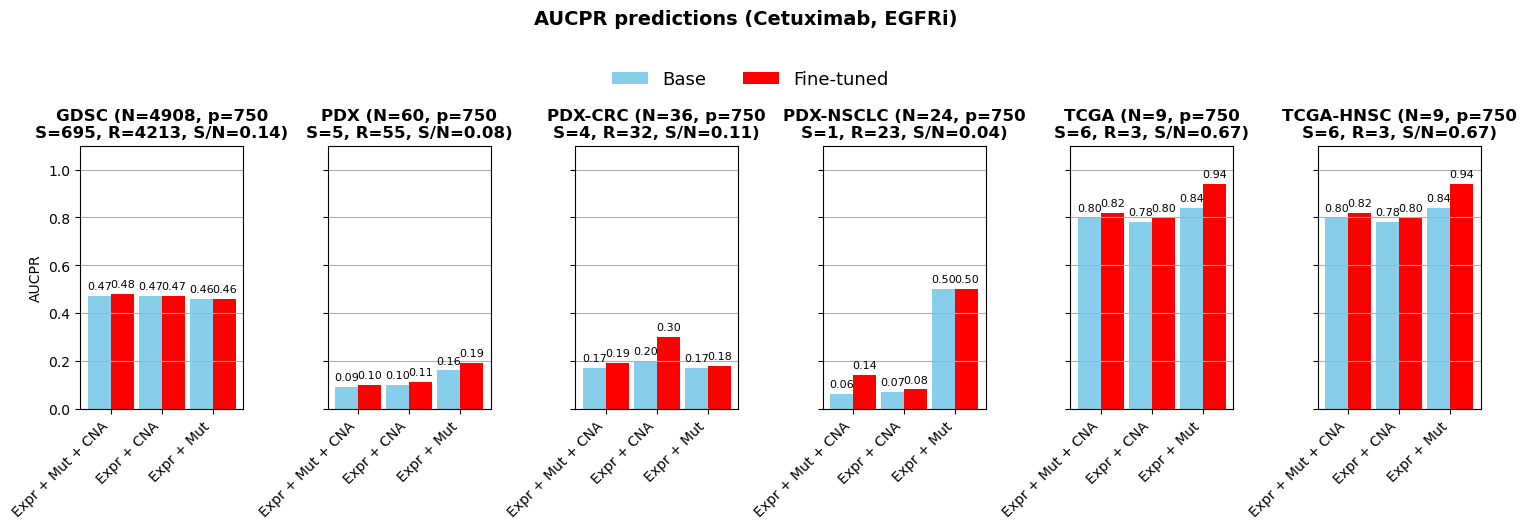

In [74]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Cetuximab, EGFRi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Cetuximab, EGFRi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [75]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Second_Strategy


In [76]:
# save predictions

file = open('GDSC_PDX_TCGA_EGFRi_Cetuximab_Predictions_Second_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (EGFRi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (EGFRi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab): {round(AUCTcetuximab_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab): {round(AUCTcetuximab_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Cetuximab): {round(AUCTcetuximab_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Cetuximab): {round(AUCTcetuximab_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc_aucpr,2)}\n")

file.close()

In [77]:
# get Gene symbols from Entrez ID

gene_list = mg.querymany(GDSCEv2.columns, 
                         species="human", 
                         scopes = "entrezgene",
                         field = "symbol",
                         as_dataframe=True)["symbol"]
gene_list

query
118788    PIK3AP1
2059         EPS8
10253       SPRY2
79887       PLBD1
94234       FOXQ1
           ...   
10217      CTDSPL
4082       MARCKS
90102      PHLDB2
55287      TMEM40
126969    SLC44A3
Name: symbol, Length: 750, dtype: object

In [78]:
# change directory to read DEG file (Cetuximab)

os.chdir(cetuximab_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/Cetuximab


In [79]:
# read DEG file (Cetuximab)

cetuximab_DEGs_data = pd.read_excel("Limma Results (EnsemblID).xlsx")
cetuximab_DEGs_data = cetuximab_DEGs_data.set_index('ID', drop=True)
cetuximab_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
ENSG00000146648,-1.253555,4.322459,-9.805216,2.134183e-21,3.889121e-17,37.631398
ENSG00000137440,-2.449874,4.442786,-9.544873,2.032909e-20,1.852285e-16,35.453883
ENSG00000168143,-0.861816,3.392488,-9.280208,1.917677e-19,1.164861e-15,33.286680
ENSG00000137699,-1.244731,3.856087,-8.693716,2.328049e-17,1.048172e-13,28.656008
ENSG00000062038,-1.979943,4.799548,-8.667179,2.875959e-17,1.048172e-13,28.452205


In [80]:
# get Gene symbols from Ensembl gene IDs

gene_symbols = mg.querymany(cetuximab_DEGs_data.index, 
                              species="human", 
                              scopes = "ensembl.gene",
                              field = "symbol",
                              as_dataframe=True)["symbol"]

gene_symbols

1 input query terms found dup hits:	[('ENSG00000226506', 2)]
15 input query terms found no hit:	['ENSG00000189144', 'ENSG00000277796', 'ENSG00000230525', 'ENSG00000258301', 'ENSG00000263574', 'ENS


query
ENSG00000146648       EGFR
ENSG00000137440     FGFBP1
ENSG00000168143     FAM83B
ENSG00000137699     TRIM29
ENSG00000062038       CDH3
                    ...   
ENSG00000137713    PPP2R1B
ENSG00000166965      RCCD1
ENSG00000144655     CSRNP1
ENSG00000107796      ACTA2
ENSG00000132254     ARFIP2
Name: symbol, Length: 18224, dtype: object

In [81]:
# merge Gene symbol column to the table

cetuximab_merged_DEGs_data = pd.merge(cetuximab_DEGs_data, pd.DataFrame(gene_symbols),  
                                       left_index=True, 
                                       right_index=True, 
                                       how='inner')

cetuximab_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000146648,-1.253555,4.322459,-9.805216,2.134183e-21,3.889121e-17,37.631398,EGFR
ENSG00000137440,-2.449874,4.442786,-9.544873,2.032909e-20,1.852285e-16,35.453883,FGFBP1
ENSG00000168143,-0.861816,3.392488,-9.280208,1.917677e-19,1.164861e-15,33.286680,FAM83B
ENSG00000137699,-1.244731,3.856087,-8.693716,2.328049e-17,1.048172e-13,28.656008,TRIM29
ENSG00000062038,-1.979943,4.799548,-8.667179,2.875959e-17,1.048172e-13,28.452205,CDH3


In [82]:
# subset DEGs in dataframe

filter = cetuximab_merged_DEGs_data["symbol"].isin(gene_list)
cetuximab_merged_DEGs_data = cetuximab_merged_DEGs_data.loc[filter,:]

cetuximab_merged_DEGs_data.head()

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol
ID,,,,,,,
ENSG00000146648,-1.253555,4.322459,-9.805216,2.134183e-21,3.889121e-17,37.631398,EGFR
ENSG00000168143,-0.861816,3.392488,-9.280208,1.917677e-19,1.164861e-15,33.286680,FAM83B
ENSG00000062038,-1.979943,4.799548,-8.667179,2.875959e-17,1.048172e-13,28.452205,CDH3
ENSG00000117595,-1.059959,3.767598,-8.432815,1.818823e-16,4.891065e-13,26.674277,IRF6
ENSG00000130702,-0.948242,4.822067,-8.332514,3.956066e-16,8.010155e-13,25.925536,LAMA5


In [83]:
# export table for pathfindR analysis

os.makedirs(pathfindR_dir, exist_ok = True)

cetuximab_merged_DEGs_data.to_csv(pathfindR_dir + "GDSC_Expression_Mutation_Filtered_DEGs_Table_EGFRi_Cetuximab_Second_Strategy.tsv",
                                   index = False,
                                   sep = "\t")

In [84]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [85]:
# read GDSC response dataset but do not exclude cetuximab (EGFRi)

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1
683665,0,-1.50094791622811,CUDC-101,1,1,1
683665,1,-0.966773876200563,EKB-569,1,1,1


In [86]:
# GDSC response dataset

responses = GDSCR
responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,1.49001536063508,Afatinib,1,1,1
683665,0,3.70042086392846,Afatinib (rescreen),1,1,1
683665,0,6.29444657935625,Cetuximab,1,1,1


In [87]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683667',
       ...
       '910930', '910941', '910941', '924248', '924248', '924248', '906849',
       '906849', '949162', '949162'],
      dtype='object', name='sample_name', length=5633)

In [88]:
# filter GDSC expression and CNA datasets as to drugs
# filter selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEcetuximab = PDXEcetuximab.loc[:,ls5]
PDXMcetuximab = PDXMcetuximab.loc[:,ls5]

TCGAEcetuximab = TCGAEcetuximab.loc[:,ls5]
TCGAMcetuximab = TCGAMcetuximab.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Cetuximab (Expression): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Cetuximab (Mutation): {PDXMcetuximab.shape}\n")

print(f"TCGA # of common samples and genes for Cetuximab (Expression): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Cetuximab (Mutation): {TCGAMcetuximab.shape}")

GDSC # of common samples and genes (Expression): (4908, 750)
GDSC # of common samples and genes (Mutation): (4908, 750)
GDSC # of common samples (Response): 5633

PDX # of common samples and genes for Cetuximab (Expression): (60, 750)
PDX # of common samples and genes for Cetuximab (Mutation): (60, 750)

TCGA # of common samples and genes for Cetuximab (Expression): (9, 750)
TCGA # of common samples and genes for Cetuximab (Mutation): (9, 750)


In [89]:
# subset sensitive and resistant cell lines in GDSC, PDX, and TCGA 

filter = (GDSCRv2["drug"] == "Cetuximab")
cetuximab_samples = GDSCRv2.loc[filter,:]

filter = (cetuximab_samples["response"] == 0)
gdsc_cetuximab_resistant_samples = cetuximab_samples.loc[filter,:].index
gdsc_cetuximab_sensitive_samples = cetuximab_samples.loc[~filter,:].index

filter = (PDXRcetuximab["response"] == 0)
pdx_cetuximab_resistant_samples = PDXRcetuximab.loc[filter,:].index
pdx_cetuximab_sensitive_samples = PDXRcetuximab.loc[~filter,:].index

filter = (TCGARcetuximab["response"] == 0)
tcga_cetuximab_resistant_samples = TCGARcetuximab.loc[filter,:].index
tcga_cetuximab_sensitive_samples = TCGARcetuximab.loc[~filter,:].index

print(f"There are {gdsc_cetuximab_sensitive_samples.shape[0]} cetuximab sensitive cell lines in GDSC")
print(f"There are {gdsc_cetuximab_resistant_samples.shape[0]} cetuximab resistant cell lines in GDSC\n")

print(f"There are {pdx_cetuximab_sensitive_samples.shape[0]} cetuximab sensitive cell lines in PDX")
print(f"There are {pdx_cetuximab_resistant_samples.shape[0]} cetuximab resistant cell lines in PDX\n")

print(f"There are {tcga_cetuximab_sensitive_samples.shape[0]} cetuximab sensitive cell lines in TCGA")
print(f"There are {tcga_cetuximab_resistant_samples.shape[0]} cetuximab resistant cell lines in TCGA")

There are 99 cetuximab sensitive cell lines in GDSC
There are 626 cetuximab resistant cell lines in GDSC

There are 5 cetuximab sensitive cell lines in PDX
There are 55 cetuximab resistant cell lines in PDX

There are 6 cetuximab sensitive cell lines in TCGA
There are 3 cetuximab resistant cell lines in TCGA


In [90]:
cetuximab_samples.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,6.29444657935625,Cetuximab,1,1,1
684057,0,6.3935613853243,Cetuximab,1,1,1
684059,0,5.91890283815806,Cetuximab,1,1,1


In [91]:
PDXRcetuximab.head(3)

,drug,response,ResponseCategory,Treatment,Treatment target,Treatment type,BestResponse,Day_BestResponse,BestAvgResponse,Day_BestAvgResponse,TimeToDouble,Day_Last,exprs,CNA,mutations
sample_name,,,,,,,,,,,,,,,
X-1027,Cetuximab,0,PD,cetuximab,EGFR,single,499.1,21,83.125,11,7.390018484288355,24,1,1,1
X-1119,Cetuximab,0,PD,cetuximab,EGFR,single,241.8,20,60.920000000000016,13,10.36156351791531,31,1,1,1
X-1156,Cetuximab,0,PD,cetuximab,EGFR,single,674.5,21,125.8,14,6.983031674208145,24,1,1,1


In [92]:
TCGARcetuximab.head(3)

,patient,cohort,drug,response,measure_of_response,exprs_sample_barcode,cna_sample_barcode,mut_sample_barcode
sample,,,,,,,,
TCGA-BA-A4IG-01A,TCGA-BA-A4IG,HNSC,Cetuximab,1,Complete Response,TCGA-BA-A4IG-01A-11R-A266-07,TCGA-BA-A4IG-01A-11D-A25X-01,TCGA-BA-A4IG-01A-11D-A25Y-08
TCGA-CN-4731-01A,TCGA-CN-4731,HNSC,Cetuximab,0,Clinical Progressive Disease,TCGA-CN-4731-01A-01R-1436-07,TCGA-CN-4731-01A-01D-1432-01,TCGA-CN-4731-01A-01D-1434-08
TCGA-CN-A49C-01A,TCGA-CN-A49C,HNSC,Cetuximab,1,Complete Response,TCGA-CN-A49C-01A-11R-A24H-07,TCGA-CN-A49C-01A-11D-A24C-01,TCGA-CN-A49C-01A-11D-A24D-08


In [93]:
# export sensitive and resistant cell lines in GDSC for pathfindR analysis

gdsc_df = pd.DataFrame(cetuximab_samples["response"])
gdsc_df = gdsc_df.reset_index()
gdsc_df.rename(columns = {"index": "Sample", "response": "Response"}, inplace = True)

gdsc_df.to_csv(pathfindR_dir + "GDSC_EGFRi_Cetuximab_Samples_Second_Strategy.tsv",
               index = False,
               sep = "\t")

In [94]:
gdsc_df.head(3)

,Sample,Response
0,683665,0
1,684057,0
2,684059,0


In [95]:
# create and export experiment matrices for GDSC, PDX and TCGA for pathfindR analysis

filter = (GDSCE.index.isin(cetuximab_samples.index))
gdsc_cetuximab_df = GDSCE.loc[filter,:].transpose()

filter = (gdsc_cetuximab_df.index.isin(GDSCEv2.columns))
gdsc_cetuximab_exp_df = gdsc_cetuximab_df.loc[filter,:]

gdsc_cetuximab_exp_df.index = mg.querymany(gdsc_cetuximab_exp_df.index,
                                            species="human",
                                            scopes = "entrezgene",
                                            field = "symbol",
                                            as_dataframe=True)["symbol"]

gdsc_cetuximab_exp_df.to_csv(pathfindR_dir + "GDSC_Experiment_Matrix_EGFRi_Cetuximab_Second_Strategy.tsv",
                              sep = "\t")

In [96]:
gdsc_cetuximab_exp_df.head(3)

,683665,684057,684059,684062,684072,684681,687452,687455,687457,687505,...,946360,949174,1240131,1240174,1240221,1298362,1322218,1331038,1659823,753608
symbol,,,,,,,,,,,,,,,,,,,,,
ACTN1,-1.3206711957875388,-1.2699003831873168,-0.3717935179646573,-1.0097600785392011,-0.6945620392040204,0.6854015673688795,0.5576527061105618,-0.0924174347432473,0.6123128833304173,0.0308495862436436,...,0.3997143891454243,-1.0139530441594116,0.2920208424572889,-0.1539298854813699,-1.0622293732305264,2.2033690476527723,-0.7460407559486447,-2.579621450781637,0.3524153306224398,0.6001877159854155
ADA,1.436681017298101,0.564012775113484,-0.0863264421063415,0.6177088620774955,0.514199291986227,0.4382670639153719,0.274716172708951,-2.173698605812095,-0.6397417447281124,0.6555533000624435,...,-0.0218615687221187,-0.4975917783642858,-0.3266911343674255,-0.2553440966695078,0.3577784079670127,-0.1919776240132578,0.4927114651228993,0.058074654895683,-0.4592714662909463,0.2405769777403358
PLIN2,0.9057392078457664,-1.3432578684351266,-1.4917752362824657,-1.356575761467189,-1.5006112577112445,0.3638960864666455,0.9239754289905672,1.4603886709054474,0.0216898882268237,-1.393714810614079,...,0.3140396474825546,0.9309798727729272,0.9851178533998708,-1.309448751258479,-1.355488260523265,-1.5041786047887884,0.7426200945677933,0.4926901399437431,0.5893002566147152,-1.1530145515964396


In [97]:
# change directory to read DEG file (Cetuximab)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [98]:
# read DEG file (Cetuximab)

cetuximab_DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                              sheet_name = "Cetuximab")
cetuximab_DEGs_filtered_data = cetuximab_DEGs_filtered_data.loc[:,["Gene.Symbol","logFC","adj.P.Val"]]

cetuximab_DEGs_filtered_data.head()

,Gene.Symbol,logFC,adj.P.Val
0,EGFR,-1.253555,3.889121e-17
1,FGFBP1,-2.449874,1.852285e-16
2,TRIM29,-1.244731,1.048172e-13
3,CDH3,-1.979943,1.048172e-13
4,IRF6,-1.059959,4.891065e-13


In [99]:
# export frequency table of DEGs (Cetuximab)
# these genes are unionized DEGs including ones found for Cetuximab. 
# There is no "Frequency = 1" in the table since  cetuximab-unique DEGs were excluded

filter = DEGs_filtered_data["Gene Symbol"].isin(cetuximab_DEGs_filtered_data["Gene.Symbol"])
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_Expression_Mutation_DEGs_Freq_Table_EGFRi_Cetuximab_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [100]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8
...,...,...
323,CXCL8,3
336,RAB20,3
338,RAB17,3
339,SULF2,3


In [101]:
# export frequency table of DEGs (EGFRi)
# these genes are unionized DEGs for all EGFR signaling inhibitors

filter = DEGs_filtered_data["Gene Symbol"].isin(gene_list)
DEGs_filtered_data.loc[filter,:].to_csv(pathfindR_dir + "GDSC_PDX_TCGA_Expression_Mutation_DEGs_Freq_Table_EGFRi_Second_Strategy.tsv",
                                        index = False,
                                        sep = "\t")

In [102]:
DEGs_filtered_data.loc[filter,:]

,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
5,RND3,8
...,...,...
1021,WIPF1,1
1022,GLCCI1,1
1024,TOM1L1,1
1026,FSTL1,1
